In [1]:
import qiskit
import qiskit.circuit.random as qiskitrandom
import qiskit.providers.aer.extensions

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import networkx as nx

import qbitmap
from qbitmap import noisemap 

/home/ares/projects/qbitmap/lib/python3.6/site-packages/qiskit/__init__.py:66: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of qiskit-terra 0.17.0. Support for running Qiskit with Python 3.6 will be removed in qiskit-terra 0.20.0.
  DeprecationWarning,


In [2]:
%load_ext autoreload
%autoreload 2

## Construct a grid with an imposed noise model

In [32]:
np.random.seed(4456)
# List the target qubits in flattened format
GOOD_QUBITS = [(3, 1), (2, 2), (1, 3),  (1, 1), (1, 2)] + [(3, 0), (3, 3), (0, 1)]

GOOD_EDGES = [
    ((2, 2), (3, 2)), ((3, 2), (3, 3)),  
    ((2, 3), (1, 3)), ((1, 1), (1, 2)), 
    ((2, 2), (2, 3)), ((3, 1), (3, 2))
]


GOOD_EDGES = GOOD_EDGES + [(t[1], t[0]) for t in GOOD_EDGES]
WIDTH, HEIGHT = 4, 4
G = nx.grid_2d_graph(WIDTH, HEIGHT)

good_1q_base = 0.001
err_1q_base = 0.010

good_2q_base = 0.005
err_2q_base = 0.035

err_1q = np.asarray([good_1q_base if q in GOOD_QUBITS else np.random.normal(err_1q_base, .005)  for q in G.nodes])
err_2q = np.asarray([good_2q_base if e in GOOD_EDGES else np.random.normal(err_2q_base, 0.01)  for e in G.edges])

# FIXME: either I fucked up big or cirq allows negative depol parameters?
# I thought I put up an issue like 2 years ago on their github......
err_1q[err_1q <= 0] = 0
err_2q[err_2q <= 0] = 0

noise_1q = {'weight': err_1q}
noise_2q = {'weight': dict(zip(G.edges, err_2q))}

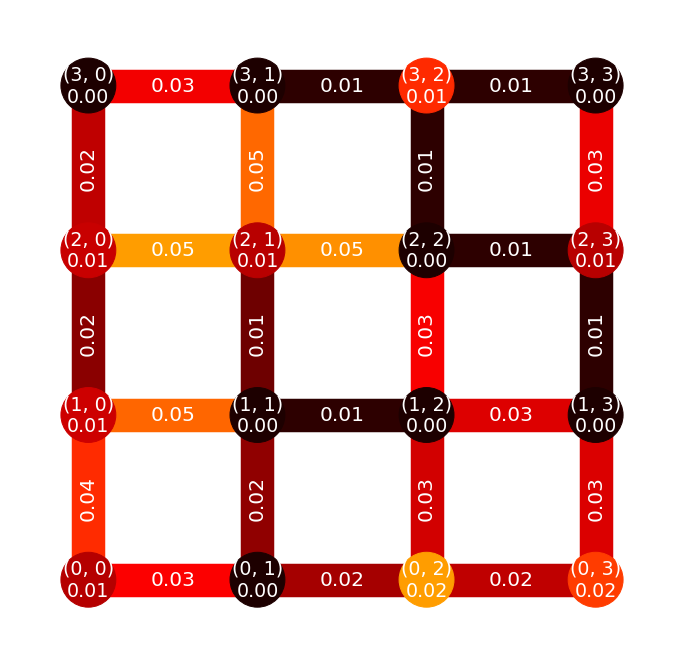

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
noise_graph, coords = qbitmap.noisemap.make_nn_connected_from_inputs(WIDTH, HEIGHT, noise_1q, noise_2q)
noisemap.plot_nn_graph_with_noise(noise_graph, coords, ax=ax, metric_1q="weight", metric_2q="weight")

### Initialize the backend

Note that the `qhardware` object is responsible for hashing grid coordinates `(row, column)` into indices and back again. As long as all transformations are made using `QProcessor2DGrid.idx_2d_to_1d` and its inverse function then we will have consistent results.

In [82]:
# QPU object
from qbitmap.qiskit._hardware import QProcessor2DGrid
qhardware = QProcessor2DGrid(nrows=HEIGHT, ncols=WIDTH)

# Initialize the 'flat' noise model
qhardware.init_noise_from_graph(noise_graph=noise_graph)

num_phys_qubits = qhardware.num_qubits
indices = list(range(num_phys_qubits))

rng_seed = 1
rng = np.random.Generator(np.random.PCG64(rng_seed))

num_logical_qubits = 4
logical_depth = 5

### Random circuit

In [85]:
from qbitmap.qiskit._transpileevaluate import TranspileEvaluate
# Random logical circuit
logical_circuit = qiskitrandom.random_circuit(num_qubits=num_logical_qubits, depth=logical_depth, seed=1)

# TranspileEvaluate object
OBJ = TranspileEvaluate(logical_circuit, qhardware)

/home/ares/projects/qbitmap/lib/python3.6/site-packages/qiskit/providers/aer/extensions/snapshot_density_matrix.py:77: DeprecationWarning: The `SnapshotDensityMatrix` instruction has been deprecated as of qiskit-aer 0.9. It has been superseded by the `SaveDensityMatrix` instructions.
  SnapshotDensityMatrix(label, num_qubits=len(snapshot_register)),
/home/ares/projects/qbitmap/lib/python3.6/site-packages/qiskit/providers/aer/extensions/snapshot_density_matrix.py:46: DeprecationWarning: The `Snapshot` instruction will be deprecated in the future. It has been superseded by the `SaveStatevector` instructions.
  num_qubits=num_qubits)


### Hyperparameter tuning and temperature scheduling

In [5]:
def T_exp(T0, alpha, steps):
    t = np.arange(steps)
    return T0 * alpha ** t

def T_log(T0, alpha, steps):
    t = np.arange(steps)
    return T0 / (1 + alpha * np.log(1 + t))

def T_lin(T0, steps):
    t = np.linspace(0, 1, steps)
    return T0 * (1 - t)

def T_poly(T0, alpha, p, steps):
    t = np.arange(steps)
    return T0 / (1 + alpha * t ** p)

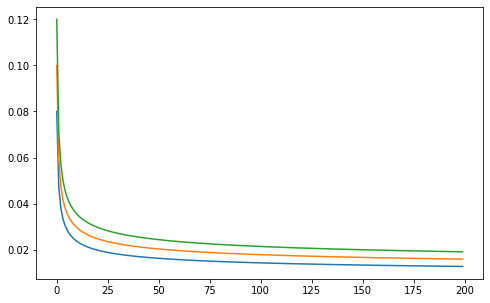

In [6]:
anneal_steps = 200
seeds = [2,3,4]
ntrials_annealer = len(seeds)

T0 = 0.08
# alpha = 0.98
p = 1

temps1 = T_log(.08, 1, anneal_steps)
temps2 = T_log(.1, 1, anneal_steps)
temps3 = T_log(.12, 1, anneal_steps)

temps_lst = [temps1, temps2, temps3]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(range(anneal_steps), temps1, label="T_exp")
ax.plot(range(anneal_steps), temps2, label="T_log")
ax.plot(range(anneal_steps), temps3, label="T_poly")
# ax.legend(loc="upper right")

In [112]:
from qbitmap.qiskit._simulated_annealing import anneal

all_results_by_temp = []
for ii, temps in enumerate(temps_lst):
    print(f"temps={ii}")
    results = []
    all_qubits = list(noise_graph.nodes)
    indices = [qhardware.idx_2d_to_1d(*q) for q in all_qubits]
    for seed in seeds:
        print("...", seed)
        # Create a qubit assignment
        rng.shuffle(indices)
        initial_layout = indices[:num_logical_qubits]

        # Transpile the circuit
        OBJ.transpile_to_physical(initial_layout=initial_layout, optimization_level = 1, routing_method = 'sabre')
        def score_func(initial_layout):
            OBJ.transpile_to_physical(initial_layout=initial_layout, optimization_level = 1, routing_method = 'sabre',)
            return OBJ.get_roundtrip_fidelity(shots=4096, seed_simulator=seed)

        anneal_results = anneal(num_phys_qubits, 
                                num_logical_qubits, 
                                score_func, 
                                temperatures=temps, 
                                steps=anneal_steps, 
                                track_history=True, 
                                anneal_seed=seed
        )
        results.append(anneal_results)
    all_results_by_temp.append(results)

temps=0
... 2
199/200 steps completed
... 3
199/200 steps completed
... 4
199/200 steps completed
temps=1
... 2
199/200 steps completed
... 3
199/200 steps completed
... 4
199/200 steps completed
temps=2
... 2
199/200 steps completed
... 3
199/200 steps completed
... 4
199/200 steps completed


In [ ]:
anneal_steps = 200
temps_opt = T_log(.08, 1, anneal_steps)
seeds = range(100)
ntrials_anneal = len(seeds)

anneal_outcomes = np.zeros((ntrials_anneal, anneal_steps +1))
anneal_unq_states = np.zeros(ntrials_anneal)
all_anneal_unq_states = np.zeros((ntrials_anneal, anneal_steps + 1))


all_qubits = list(noise_graph.nodes)
indices = [qhardware.idx_2d_to_1d(*q) for q in all_qubits]


for i in range(ntrials_anneal):
    seed = seeds[i]  
    rng.shuffle(indices)
    initial_layout = indices[:num_logical_qubits]

    # Transpile the circuit
    OBJ.transpile_to_physical(initial_layout=initial_layout, optimization_level = 1, routing_method = 'sabre')
    def score_func(initial_layout):
        OBJ.transpile_to_physical(initial_layout=initial_layout, optimization_level = 1, routing_method = 'sabre',)
        return OBJ.get_roundtrip_fidelity(shots=4096, seed_simulator=seed)

    history = anneal(num_phys_qubits, 
                            num_logical_qubits, 
                            score_func, 
                            temperatures=temps_opt, 
                            steps=anneal_steps, 
                            track_history=True, 
                            anneal_seed=seed
    )
    anneal_unq_states[i] = history['unique_states_counter'][-1]
    all_anneal_unq_states[i] = history['unique_states_counter']
    anneal_outcomes[i,:] = history['score_history']
    

In [168]:
ntrials_random = 10

unq_cts = np.unique(anneal_unq_states)
random_results = np.zeros((len(unq_cts), ntrials_random))

for i in range(ntrials_random):
    print(f"trials={i}")
    # Each random trial will sample `cts`-many random circuits, for each
    # occurence of cts in the annealer histories set
    for j, cts in enumerate(unq_cts):
        # For each total counts from an SA, perform random trials for that same number of counts
        random_batch = []
        for _ in range(int(cts)): 
            # In each random trial, 
            rng.shuffle(indices)
            initial_layout = indices[:num_logical_qubits]
            # Transpile the circuit
            OBJ.transpile_to_physical(initial_layout=initial_layout, optimization_level = 1, routing_method = 'sabre')
            def score_func(initial_layout):
                OBJ.transpile_to_physical(initial_layout=initial_layout, optimization_level = 1, routing_method = 'sabre',)
                return OBJ.get_roundtrip_fidelity(shots=4096, seed_simulator=seed)
            score = score_func(initial_layout)
            random_batch.append(score)

        random_results[j,i] = max(random_batch)
        
        
np.save("anneal_unq_states.npy", anneal_unq_states)
np.save("all_anneal_unq_states.npy", all_anneal_unq_states)
np.save("anneal_outcomes.npy", anneal_outcomes)
np.save("random_results.npy", random_results)    

trials=0
trials=1
trials=2
trials=3
trials=4
trials=5
trials=6
trials=7
trials=8
trials=9


## Plot figure for all-to-all connectivity SA

In [24]:
anneal_unq_states = np.load("anneal_unq_states.npy")
all_anneal_unq_states = np.load("all_anneal_unq_states.npy")
anneal_outcomes = np.load("anneal_outcomes.npy")
random_results = np.load("random_results.npy")

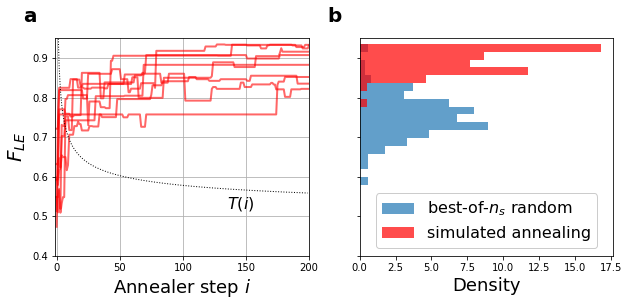

In [22]:
plt.style.use('../../style.mplstyle')

best_score = 1

anneal_steps = 200
temps_opt = T_log(.08, 1, anneal_steps)
seeds = range(100)
ntrials_anneal = len(seeds)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

random_subset_to_show = np.random.choice(range(ntrials_anneal), replace=False, size=8)

for j in random_subset_to_show:
#     if j != 4:
#         continue
    anneal_results = anneal_outcomes[j,:]
    axes[0].plot(range(anneal_steps+1), anneal_results/ best_score, lw=2, label=seeds[j], alpha=0.6, c='r')   

# Arbitrary log plot
axes[0].plot(range(anneal_steps), temps_opt[:anneal_steps] / max(temps_opt) + 0.4, linewidth=1, c='k', ls=':')

anneal_best = np.max(anneal_outcomes, axis=1)

cts, bins, _ = axes[1].hist(random_results.flatten(), orientation="horizontal", 
                            density=True, alpha=0.7, bins='auto', label=r"best-of-$n_s$ random")
axes[1].hist(anneal_best, orientation="horizontal", color='r', 
             density=True, alpha=0.7, bins=bins, label="simulated annealing")


ax.set_xlim(-2, anneal_steps+2)
ax.set_xticks(range(0, anneal_steps+1, 10))
ax.set_xticklabels(range(0, anneal_steps+1, 10), fontsize=14)

labelsize = 18
axes[0].set_ylim(0.4, 0.95)
axes[0].set_xlim(-1, anneal_steps)
axes[0].set_ylabel(r"$F_{LE}$", fontsize=labelsize+2)
axes[0].set_xlabel('Annealer step $i$', fontsize=labelsize)
axes[0].text(135, 0.52, r"$T(i)$", size=16)
axes[0].grid()
# axes[1].grid(axis='y')
axes[0].text(-0.1, 1.1, r"a", horizontalalignment='center', verticalalignment='center', size=20, transform=axes[0].transAxes, weight="bold")


axes[1].legend(loc="lower center", prop={'size': 16}, framealpha=1)
axes[1].set_xlabel("Density", size=labelsize)
axes[1].text(-0.1, 1.1, r"b", horizontalalignment='center', verticalalignment='center', size=20, transform=axes[1].transAxes, weight="bold")

fig.savefig("../../figures/all_to_all_SA.pdf",bbox_inches='tight')